In [2]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load datasets
# Load and preprocess the data
humidityData = pd.read_csv("../Dataset/colombo_rh_2012-2018.csv")
temperatureData = pd.read_csv("../Dataset/colombo_t_2012-2018.csv")

# Merge datasets on common columns
TempHumidDataset = pd.merge(humidityData, temperatureData, on=['station_id', 'year', 'month', 'day'])

TempHumidDataset
# Drop unnecessary columns
TempHumidDataset.drop(columns=['station_name_x','station_name_y','element_name_x','element_name_y'], inplace=True)

# Convert numeric columns to appropriate data types
TempHumidDataset['obs_val_x'] = pd.to_numeric(TempHumidDataset['obs_val_x'], errors='coerce')
TempHumidDataset['obs_val_y'] = pd.to_numeric(TempHumidDataset['obs_val_y'], errors='coerce')

# Drop rows with NaN values
TempHumidDataset.dropna(subset=['obs_val_x', 'obs_val_y'], inplace=True)

TempHumidDataset['obs_val_y'] = (TempHumidDataset['obs_val_y'] * 9/5) + 32

# Calculate Heat Index
def heatIndexCalculation(T, RH):
    HI = (-42.379 + 2.04901523*T + 10.14333127*RH - 0.22475541*T*RH 
          - 0.00683783*T*T - 0.05481717*RH*RH + 0.00122874*T*T*RH 
          + 0.00085282*T*RH*RH - 0.00000199*T*T*RH*RH)
    return HI

TempHumidDataset['heatIndex'] = heatIndexCalculation(TempHumidDataset['obs_val_y'], TempHumidDataset['obs_val_x'])
TempHumidDataset

# Handle missing values
TempHumidDataset.fillna(method='ffill', inplace=True) # Forward fill missing values

TempHumidDataset.isnull().sum()

TempHumidDataset.drop(['station_id'], axis=1, inplace=True)

TempHumidDataset = TempHumidDataset.rename(columns={'obs_val_x': 'rh_val', 'obs_val_y': 'tf_val'})

# Resample data to daily frequency (if needed)
TempHumidDataset['date'] = pd.to_datetime(TempHumidDataset[['year', 'month', 'day']], format="%Y%m%d", errors='coerce')
TempHumidDataset.set_index('date', inplace=True)
TempHumidDataset = TempHumidDataset.resample('D').mean()

# Explicitly set the frequency of the date index
TempHumidDataset.index.freq = 'D'

# Remove duplicates
TempHumidDataset = TempHumidDataset.loc[~TempHumidDataset.index.duplicated(keep='first')]

# Drop unnecessary columns
TempHumidDataset.drop(['year', 'month', 'day'], axis=1, inplace=True)

# Train ARIMA model
model = ARIMA(TempHumidDataset['heatIndex'], order=(40, 0, 9))
model_fit = model.fit()

# Predictions
predictions = model_fit.predict(typ='levels')

# Calculate RMSE
rmse = sqrt(mean_squared_error(TempHumidDataset['heatIndex'], predictions))
print("Root Mean Squared Error (RMSE):", rmse)

c:\Users\cheha\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Root Mean Squared Error (RMSE): 4.971937198431951


In [3]:
TempHumidDataset.head()

,rh_val,tf_val,heatIndex
date,,,
2012-01-01,91.0,86.18,106.586916
2012-01-02,90.0,87.26,110.222986
2012-01-03,89.0,88.88,116.153191
2012-01-04,89.0,86.72,107.436420
2012-01-05,95.0,90.14,127.316863


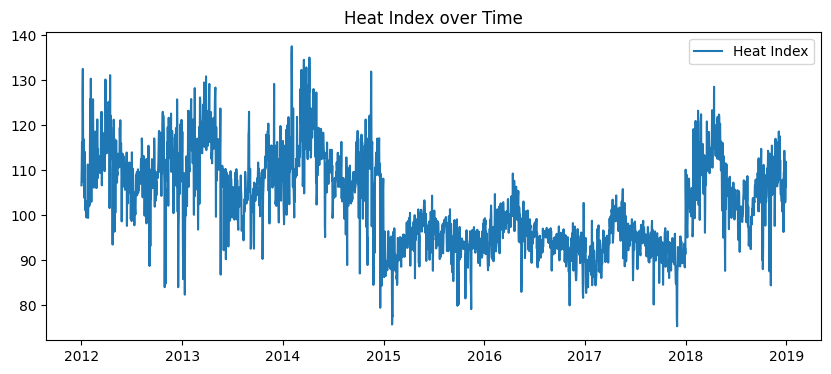

In [4]:
# Plot Heat Index
plt.figure(figsize=(10, 4))
plt.plot(TempHumidDataset['heatIndex'], label='Heat Index')
plt.title('Heat Index over Time')
plt.legend()
plt.show()

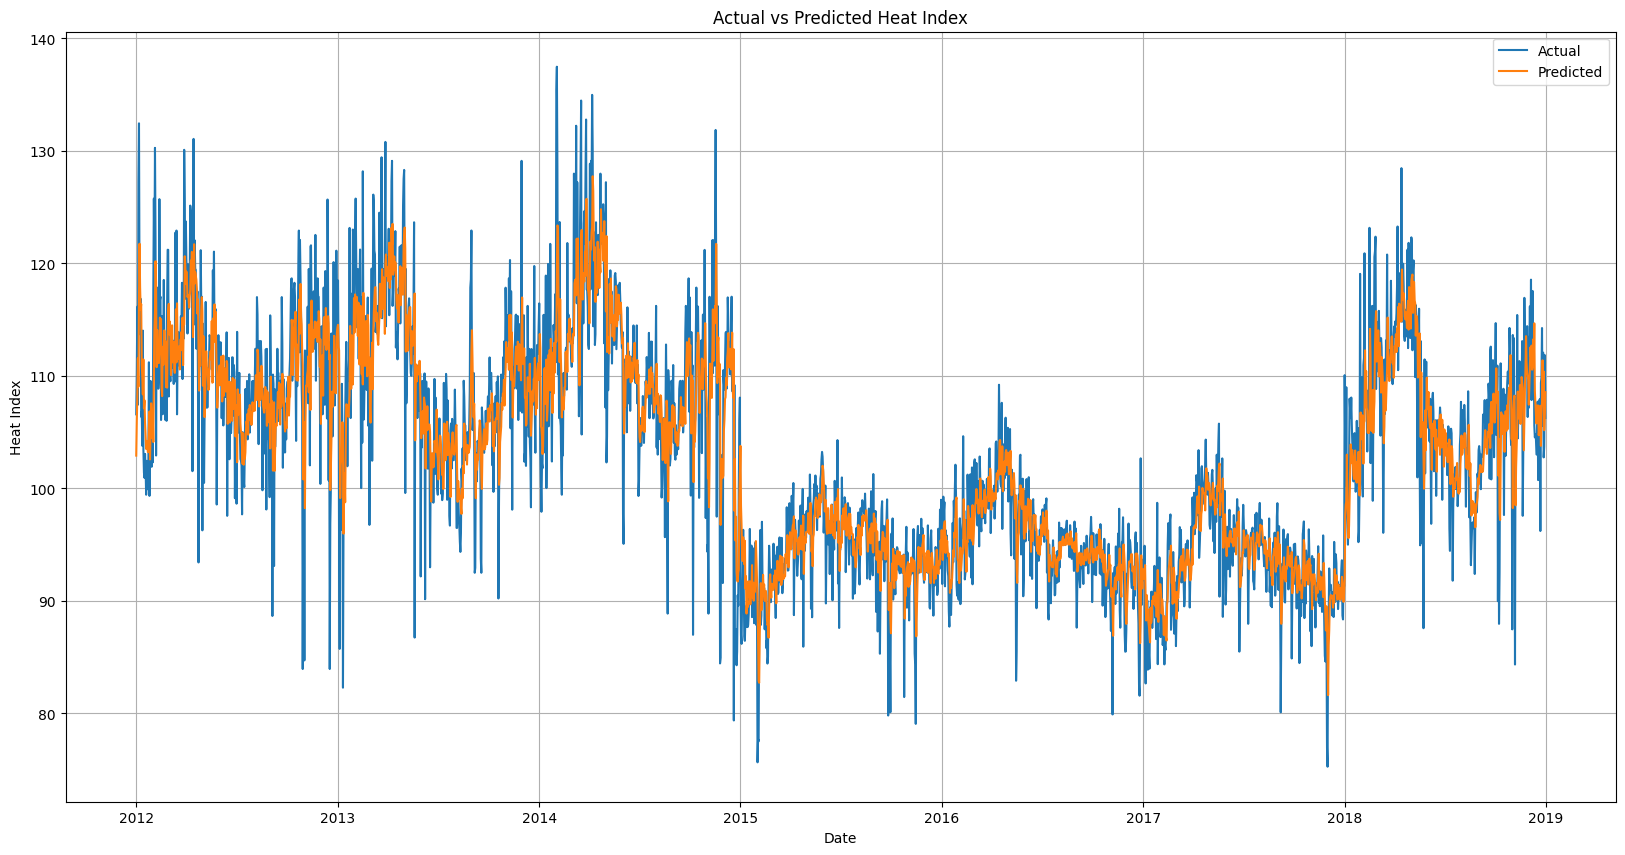

In [5]:
# Plot actual and predicted values
plt.figure(figsize=(20, 10))
plt.plot(TempHumidDataset.index, TempHumidDataset['heatIndex'], label='Actual')
plt.plot(TempHumidDataset.index, predictions, label='Predicted')
plt.title('Actual vs Predicted Heat Index')
plt.xlabel('Date')
plt.ylabel('Heat Index')
plt.legend()
plt.grid(True)
plt.show()

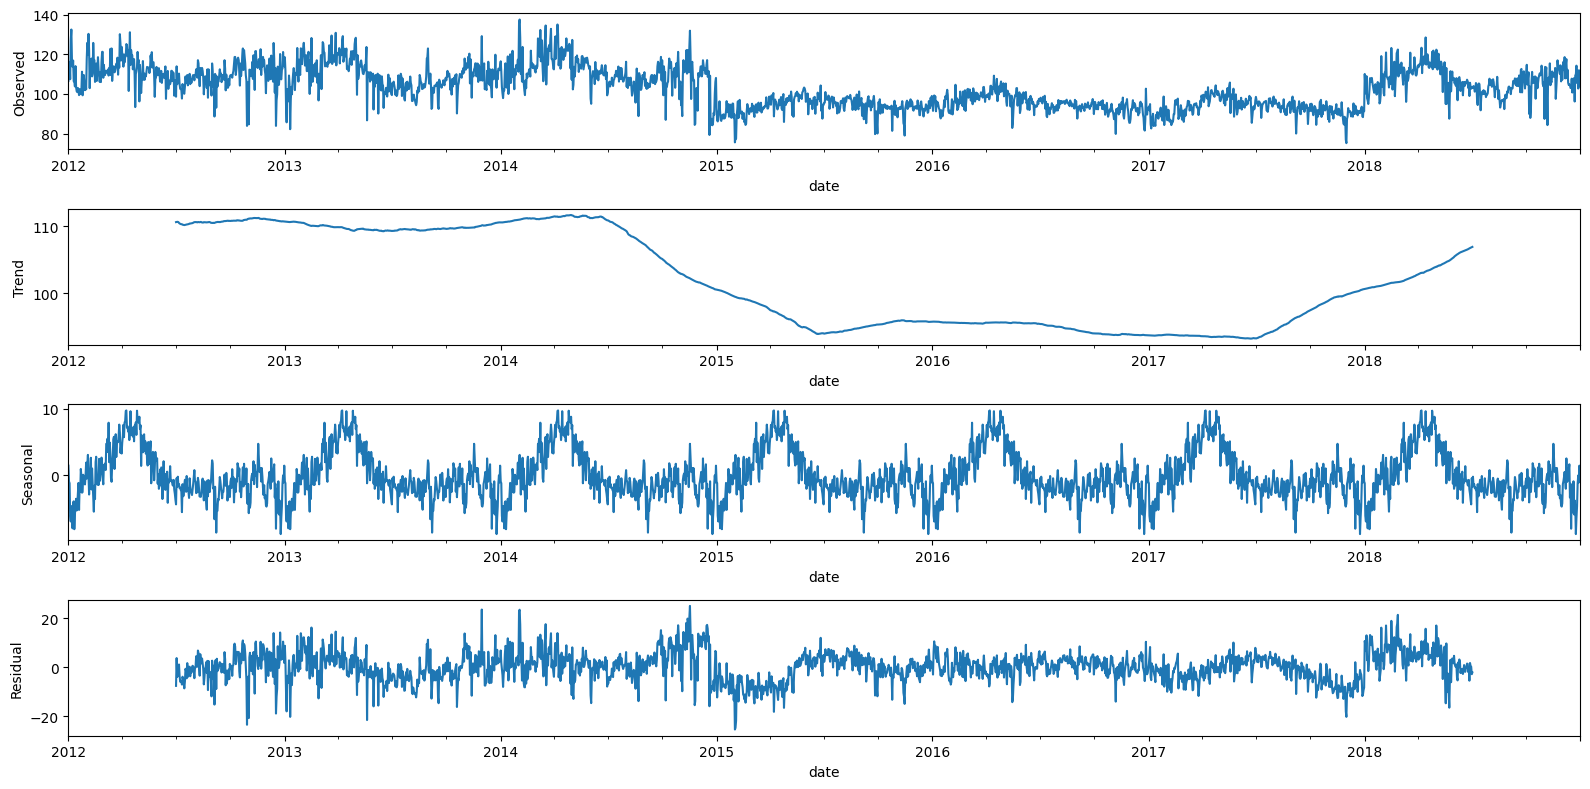

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(TempHumidDataset['heatIndex'], model='additive', period=365)

# Plot the decomposed components
fig, ax = plt.subplots(4, 1, figsize=(16, 8))

decomposition.observed.plot(ax=ax[0])
ax[0].set_ylabel('Observed')
decomposition.trend.plot(ax=ax[1])
ax[1].set_ylabel('Trend')
decomposition.seasonal.plot(ax=ax[2])
ax[2].set_ylabel('Seasonal')
decomposition.resid.plot(ax=ax[3])
ax[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

In [7]:
from datetime import datetime
import pandas as pd

# Get today's date
today = datetime.today()

# Calculate the start date for the forecast (1 year back)
forecastingSteps = 365
forecastStarting = today - pd.DateOffset(days=forecastingSteps)
forecastStarting = forecastStarting.strftime('%Y-%m-%d')

# Generate the date range for the forecast
forecastingIndex = pd.date_range(start=forecastStarting, periods=forecastingSteps, freq='D')

# Generate the forecast values
forecast = model_fit.forecast(steps=forecastingSteps)
forecastingPastDataset = pd.DataFrame({
    'date': forecastingIndex.date,
    'values': forecast
})

# Print the forecasted values
print('\nForecasted Heat Index for the past 12 months:')
print(forecastingPastDataset)
forecastingPastDataset.to_csv('../Dataset/PredictedData/predicted_data_past.csv', index=False)


Forecasted Heat Index for the past 12 months:
                  date      values
2019-01-01  2023-05-18  108.028960
2019-01-02  2023-05-19  106.440926
2019-01-03  2023-05-20  107.210841
2019-01-04  2023-05-21  107.778442
2019-01-05  2023-05-22  107.592588
...                ...         ...
2019-12-27  2024-05-12  103.629729
2019-12-28  2024-05-13  103.626451
2019-12-29  2024-05-14  103.623105
2019-12-30  2024-05-15  103.619839
2019-12-31  2024-05-16  103.616624

[365 rows x 2 columns]


In [8]:
forecastingSteps = 365
# Create a date column

today = datetime.today().strftime('%Y-%m-%d')
forecastingIndex = pd.date_range(start=today, periods=forecastingSteps + 1, freq='D')[1:]
forecast = model_fit.forecast(steps=forecastingSteps)
forecastingFutureDataset = pd.DataFrame({
                            'date': forecastingIndex.date,
                            'values': forecast})
print('Forecasted Heat Index for the next 12 months:')
print(forecastingFutureDataset)
forecastingFutureDataset.to_csv('../Dataset/PredictedData/predicted_data_future.csv', index=False)

Forecasted Heat Index for the next 12 months:
                  date      values
2019-01-01  2024-05-18  108.028960
2019-01-02  2024-05-19  106.440926
2019-01-03  2024-05-20  107.210841
2019-01-04  2024-05-21  107.778442
2019-01-05  2024-05-22  107.592588
...                ...         ...
2019-12-27  2025-05-13  103.629729
2019-12-28  2025-05-14  103.626451
2019-12-29  2025-05-15  103.623105
2019-12-30  2025-05-16  103.619839
2019-12-31  2025-05-17  103.616624

[365 rows x 2 columns]


In [9]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Convert the date columns to datetime if not already done
forecastingPastDataset['date'] = pd.to_datetime(forecastingPastDataset['date'])
forecastingFutureDataset['date'] = pd.to_datetime(forecastingFutureDataset['date'])

# Perform the ADF test for past forecast data
past_forecast_adf_result = adfuller(forecastingPastDataset['values'])
print('ADF Statistic for Past Data:', past_forecast_adf_result[0])
print('P-Value for Past Data:', past_forecast_adf_result[1])
print('Critical Values for Past Data:')
for key, value in past_forecast_adf_result[4].items():
    print(f'   {key}: {value}')

print()

# Perform the ADF test for future forecast data
future_forecast_adf_result = adfuller(forecastingFutureDataset['values'])
print('ADF Statistic for Future Data:', future_forecast_adf_result[0])
print('P-Value for Future Data:', future_forecast_adf_result[1])
print('Critical Values for Future Data:')
for key, value in future_forecast_adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic for Past Data: -2.6314197498038987
P-Value for Past Data: 0.08667574589037746
Critical Values for Past Data:
   1%: -3.449336554273722
   5%: -2.8699055166063085
   10%: -2.571226758215748

ADF Statistic for Future Data: -2.6314197498038987
P-Value for Future Data: 0.08667574589037746
Critical Values for Future Data:
   1%: -3.449336554273722
   5%: -2.8699055166063085
   10%: -2.571226758215748


In [10]:
!pip install statsmodels


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


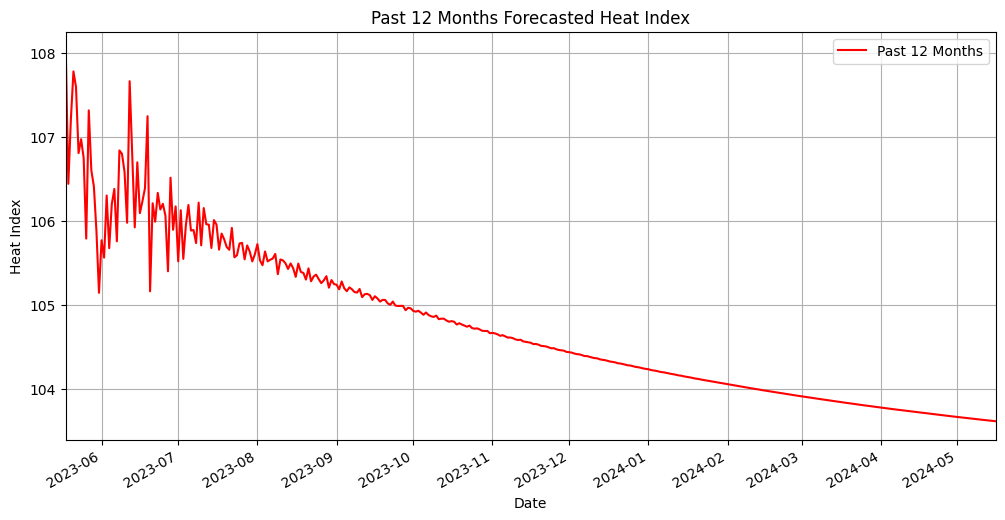

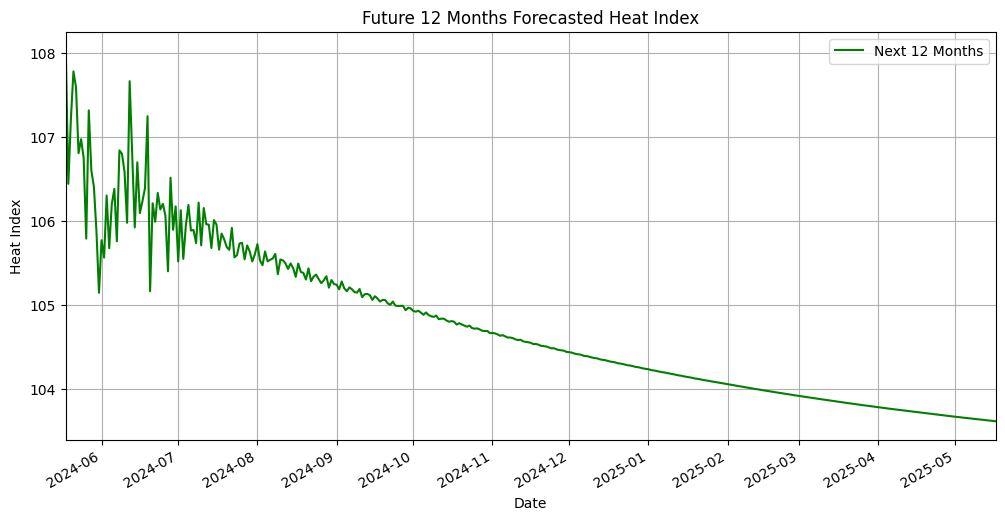

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ensure the date columns are in datetime format
forecastingPastDataset['date'] = pd.to_datetime(forecastingPastDataset['date'])
forecastingFutureDataset['date'] = pd.to_datetime(forecastingFutureDataset['date'])

# Plot the forecasted values for the past 12 months
plt.figure(figsize=(12, 6))
plt.plot(forecastingPastDataset['date'], forecastingPastDataset['values'], label='Past 12 Months', color='red')
plt.xlabel('Date')
plt.ylabel('Heat Index')
plt.title('Past 12 Months Forecasted Heat Index')
plt.xlim(forecastingPastDataset['date'].iloc[0], forecastingPastDataset['date'].iloc[-1])
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.grid(True)
plt.show()

# Plot the forecasted values for the next 12 months
plt.figure(figsize=(12, 6))
plt.plot(forecastingFutureDataset['date'], forecastingFutureDataset['values'], label='Next 12 Months', color='green')
plt.xlabel('Date')
plt.ylabel('Heat Index')
plt.title('Future 12 Months Forecasted Heat Index')
plt.xlim(forecastingFutureDataset['date'].iloc[0], forecastingFutureDataset['date'].iloc[-1])
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.grid(True)
plt.show()


In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt

# Assuming TempHumidDataset is already prepared as in your previous code

# Train SARIMA model
model = SARIMAX(TempHumidDataset['heatIndex'], order=(1, 0, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()

# Predictions
predictions = model_fit.predict(start=0, end=len(TempHumidDataset)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(TempHumidDataset['heatIndex'], predictions))
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 9.385291408588603


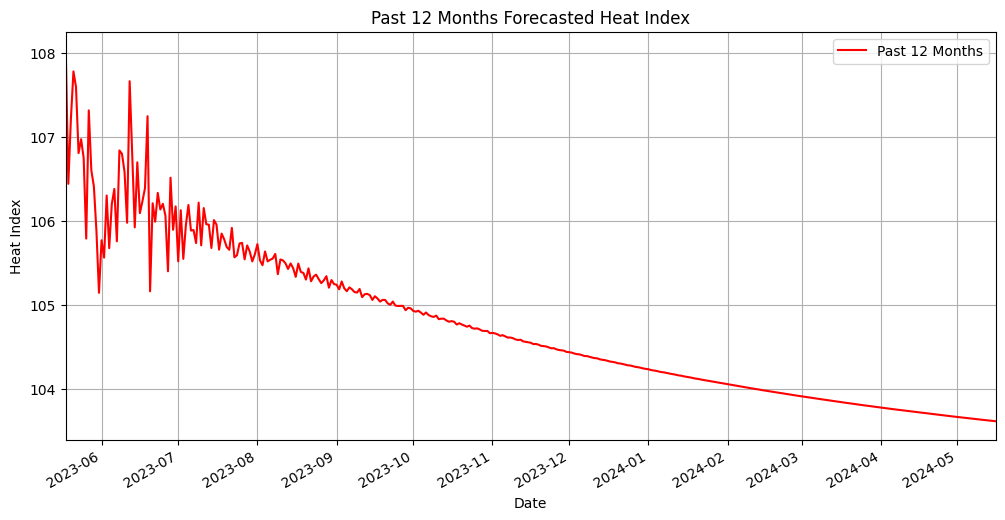

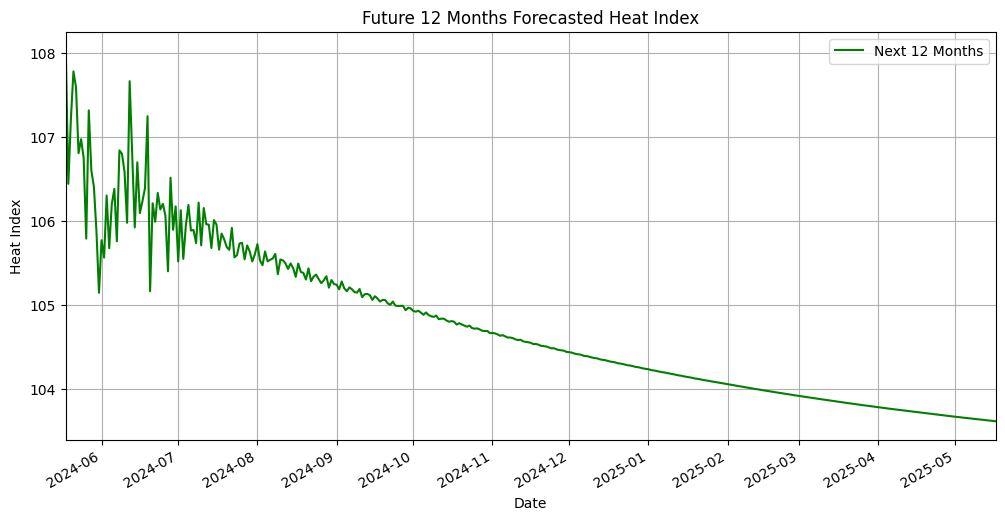

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Assuming forecastingPastDataset and forecastingFutureDataset are already prepared with date and values columns

# Ensure the date columns are in datetime format
forecastingPastDataset['date'] = pd.to_datetime(forecastingPastDataset['date'])
forecastingFutureDataset['date'] = pd.to_datetime(forecastingFutureDataset['date'])

# Plot the forecasted values for the past 12 months
plt.figure(figsize=(12, 6))
plt.plot(forecastingPastDataset['date'], forecastingPastDataset['values'], label='Past 12 Months', color='red')
plt.xlabel('Date')
plt.ylabel('Heat Index')
plt.title('Past 12 Months Forecasted Heat Index')
plt.xlim(forecastingPastDataset['date'].iloc[0], forecastingPastDataset['date'].iloc[-1])
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.grid(True)
plt.show()

# Plot the forecasted values for the next 12 months
plt.figure(figsize=(12, 6))
plt.plot(forecastingFutureDataset['date'], forecastingFutureDataset['values'], label='Next 12 Months', color='green')
plt.xlabel('Date')
plt.ylabel('Heat Index')
plt.title('Future 12 Months Forecasted Heat Index')
plt.xlim(forecastingFutureDataset['date'].iloc[0], forecastingFutureDataset['date'].iloc[-1])
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.grid(True)
plt.show()


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2557
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -7761.043
Date:                Fri, 17 May 2024   AIC                          15534.086
Time:                        09:09:38   BIC                          15569.163
Sample:                    01-01-2012   HQIC                         15546.806
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1874      0.093     -2.016      0.044      -0.370      -0.005
ar.L2          0.6182      0.057     10.782      0.000       0.506       0.731
ma.L1         -0.4325      0.096     -4.521      0.0

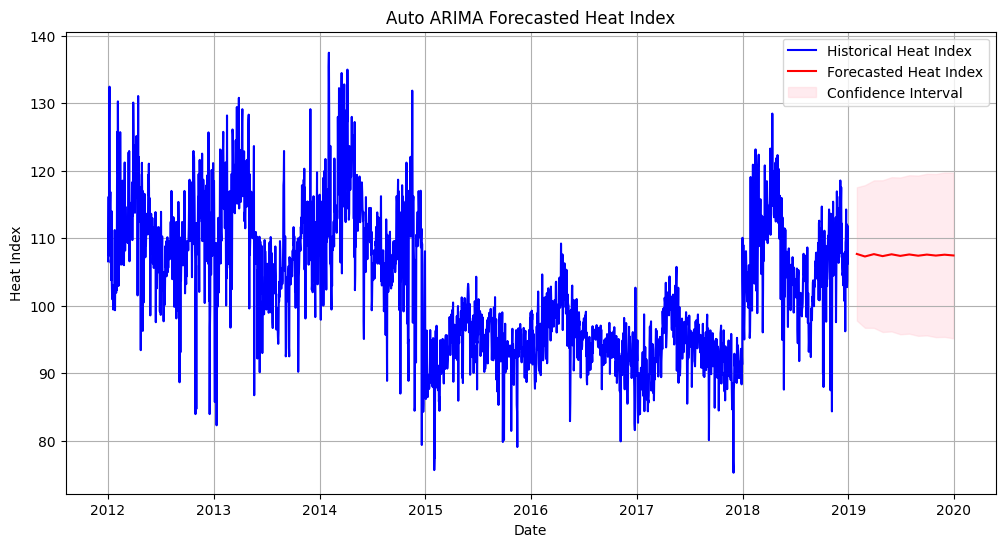

In [14]:
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# Assuming TempHumidDataset is already prepared with a date index and 'heatIndex' column

# Fit Auto ARIMA model
model = auto_arima(TempHumidDataset['heatIndex'], seasonal=True, m=12)  # Assuming monthly seasonality

# Summary of the model
print(model.summary())

# Forecast future values
future_forecast, conf_int = model.predict(n_periods=12, return_conf_int=True)

# Plot the forecasted values with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(TempHumidDataset.index, TempHumidDataset['heatIndex'], label='Historical Heat Index', color='blue')
plt.plot(pd.date_range(start=TempHumidDataset.index[-1], periods=13, freq='M')[1:], future_forecast,
         label='Forecasted Heat Index', color='red')
plt.fill_between(pd.date_range(start=TempHumidDataset.index[-1], periods=13, freq='M')[1:], conf_int[:, 0], conf_int[:, 1],
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Heat Index')
plt.title('Auto ARIMA Forecasted Heat Index')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# Forecasting future steps
forecastingSteps = 365
today = datetime.today().strftime('%Y-%m-%d')
forecastingIndex = pd.date_range(start=today, periods=forecastingSteps + 1, freq='D')[1:]
forecast = model_fit.predict(start=len(TempHumidDataset), end=len(TempHumidDataset) + forecastingSteps - 1)

# Create forecastingFutureDataset DataFrame
forecastingFutureDataset = pd.DataFrame({
    'date': forecastingIndex,
    'values': forecast
})

# Save the forecasted data to a CSV file
forecastingFutureDataset.to_csv('../Dataset/PredictedData/predicted_data_future_autoArima.csv', index=False)

print('Forecasted Heat Index for the next 12 months:')
print(forecastingFutureDataset)

Forecasted Heat Index for the next 12 months:
                 date      values
2019-01-01 2024-05-18  106.961565
2019-01-02 2024-05-19  107.321972
2019-01-03 2024-05-20  107.536682
2019-01-04 2024-05-21  106.679511
2019-01-05 2024-05-22  106.474641
...               ...         ...
2019-12-27 2025-05-13  101.384951
2019-12-28 2025-05-14  101.866473
2019-12-29 2025-05-15  101.799557
2019-12-30 2025-05-16  101.541272
2019-12-31 2025-05-17  101.478995

[365 rows x 2 columns]


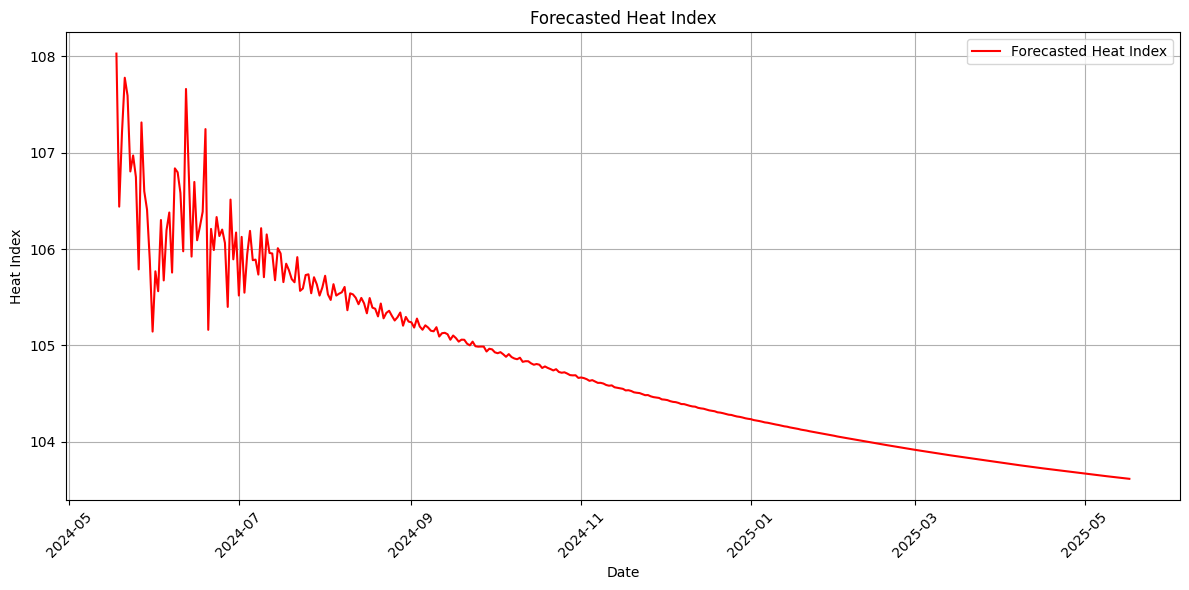

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the predicted data
forecastingFutureDataset = pd.read_csv('../Dataset/PredictedData/predicted_data_future.csv')

# Convert 'date' column to datetime format
forecastingFutureDataset['date'] = pd.to_datetime(forecastingFutureDataset['date'])

# Plotting forecasted data
plt.figure(figsize=(12, 6))
plt.plot(forecastingFutureDataset['date'], forecastingFutureDataset['values'], color='red', label='Forecasted Heat Index')

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Heat Index')
plt.title('Forecasted Heat Index')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()



In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
from datetime import datetime

# Fit the SARIMA model
model = SARIMAX(TempHumidDataset['heatIndex'], order=(1, 0, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()

# Define the start and end date for the forecast
start_date = datetime(2024, 5, 5)
end_date = datetime(2025, 5, 5)
forecastingSteps = (end_date - start_date).days

# Forecast future values
forecast = model_fit.get_forecast(steps=forecastingSteps)
forecast_index = pd.date_range(start=start_date, periods=forecastingSteps, freq='D')
forecastingFutureDataset = pd.DataFrame({
    'date': forecast_index,
    'values': forecast.predicted_mean
})

# Save the forecast to CSV
forecastingFutureDataset.to_csv('../Dataset/PredictedData/NewPrediction.csv', index=False)

# Print the forecast
print(forecastingFutureDataset)



                 date      values
2019-01-01 2024-05-05  106.961565
2019-01-02 2024-05-06  107.321972
2019-01-03 2024-05-07  107.536682
2019-01-04 2024-05-08  106.679511
2019-01-05 2024-05-09  106.474641
...               ...         ...
2019-12-27 2025-04-30  101.384951
2019-12-28 2025-05-01  101.866473
2019-12-29 2025-05-02  101.799557
2019-12-30 2025-05-03  101.541272
2019-12-31 2025-05-04  101.478995

[365 rows x 2 columns]


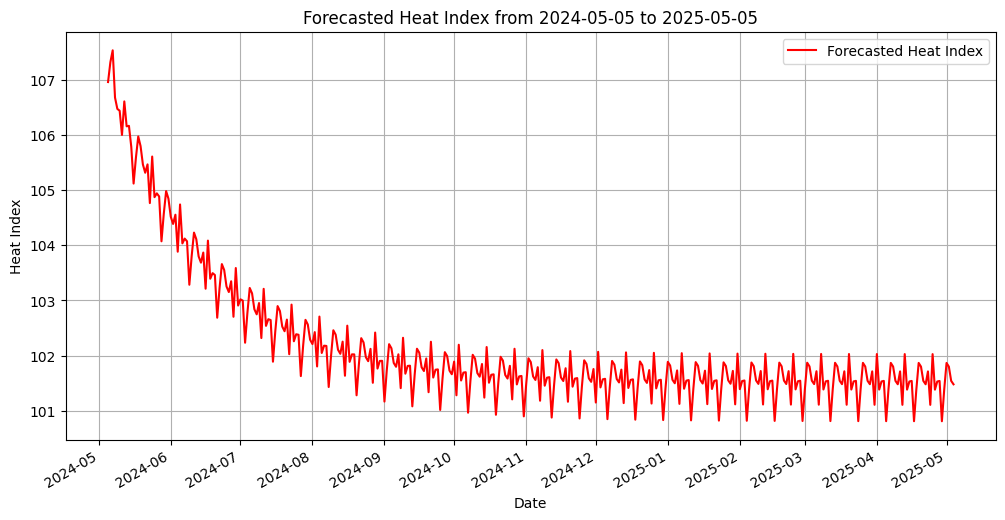

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the forecasted data
forecastingFutureDataset = pd.read_csv('../Dataset/PredictedData/NewPrediction.csv')

# Ensure the 'date' column is in datetime format
forecastingFutureDataset['date'] = pd.to_datetime(forecastingFutureDataset['date'])

# Plot the forecasted values
plt.figure(figsize=(12, 6))
plt.plot(forecastingFutureDataset['date'], forecastingFutureDataset['values'], label='Forecasted Heat Index', color='red')
plt.xlabel('Date')
plt.ylabel('Heat Index')
plt.title('Forecasted Heat Index from 2024-05-05 to 2025-05-05')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.grid(True)
plt.show()
